<a href="https://colab.research.google.com/github/josealgruiz/SYDE_Project2/blob/main/SYDE770_Project_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import random

Seed function for reproducibility

In [ ]:
def random_seed(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
        
random_seed(113) 

Loading Data

In [ ]:
datatrain = pd.read_csv('./penguins-clean-train.csv')
datatest = pd.read_csv('./penguins-clean-test.csv')

Data Preprocessing

In [ ]:
#Section 1.2 Preprocessing

#change string value to numeric
datatrain.loc[datatrain['species']=='Adelie', 'species']=0
datatrain.loc[datatrain['species']=='Gentoo', 'species']=1
datatrain.loc[datatrain['species']=='Chinstrap', 'species']=2
datatrain = datatrain.apply(pd.to_numeric)

datatest.loc[datatest['species']=='Adelie', 'species']=0
datatest.loc[datatest['species']=='Gentoo', 'species']=1
datatest.loc[datatest['species']=='Chinstrap', 'species']=2
datatest = datatest.apply(pd.to_numeric)

#change dataframe to array
datatrain_array = datatrain.values
datatest_array = datatest.values


#split x and y (feature and target)
xtrain = datatrain_array[:,1:]
ytrain = datatrain_array[:,0]
xtest = datatest_array[:,1:]
ytest = datatest_array[:,0]

#standardize
#palmer-penguin dataset has varying scales
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

Optimizers

In [ ]:
#@title ADAM
import math
from torch.optim import Optimizer

class ADAMITOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(ADAMITOptimizer, self).__init__(params, defaults)
        
    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:

            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 
                
                if state['step']  % 10000 ==0:
                    print ("group:", group)
                    print("p: ",p)
                    print("p.data: ", p.data) # W = p.data
                
        return loss

In [ ]:
#@title AdaBound
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

In [ ]:
#@title ND-Adam
import math
import torch
from torch.optim import Optimizer


class NDAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, vec_axes=None):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, vec_axes=vec_axes)
        super(NDAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('ND-Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    if group['vec_axes']:
                        shape = list(p.size())
                        for i in group['vec_axes']:
                            shape[i] = 1
                        state['exp_avg_sq'] = torch.zeros(shape)
                        if torch.cuda.is_available():
                            state['exp_avg_sq'] = state['exp_avg_sq'].cuda()
                    else:
                        state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                if group['vec_axes']:
                    g_proj = grad * p.data
                    for i in group['vec_axes']:
                        g_proj = torch.sum(g_proj, i, True)
                    grad.add_(-g_proj * p.data)
                    exp_avg.mul_(beta1).add_(1 - beta1, grad)
                    g_sqr = grad * grad
                    for i in group['vec_axes']:
                        g_sqr = torch.sum(g_sqr, i, True)
                    exp_avg_sq.mul_(beta2).add_(1 - beta2, g_sqr)
                else:
                    exp_avg.mul_(beta1).add_(1 - beta1, grad)
                    exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                if group['vec_axes']:
                    norm = p.data * p.data
                    for i in group['vec_axes']:
                        norm = torch.sum(norm, i, True)
                    norm.sqrt_()
                    p.data.div_(norm)

        return loss

Define the MLP Model

In [ ]:
## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, hl)
        self.fc2 = nn.Linear(hl,3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the NN
model = Net()
print(model)

# loss function
criterion = nn.CrossEntropyLoss()


Net(
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Train

In [ ]:
def train(n_epochs):
  X = torch.Tensor(xtrain).float()
  Y = torch.Tensor(ytrain).long()
  model.train() # prep model for training
  # monitor training loss
  train_loss = 0.0
  # clear the gradients of all optimized variables
  optimizer.zero_grad()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(X)
  # calculate the loss
  loss = criterion(output, Y)
  # backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()
  # perform a single optimization step (parameter update)
  optimizer.step()
  # update running training loss
  acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
  return acc.item(),loss.item()
  print ('Epoch [%d/%d] Loss: %.4f   Acc: %.4f' %(epoch+1, num_epoch, loss.item(), acc.item()))
    

Test

In [ ]:
def test(n_epochs):
  X = torch.Tensor(xtest).float()
  Y = torch.Tensor(ytest).long()

  model.eval() # prep model for training
  # monitor training loss
  test_loss = 0.0
  # clear the gradients of all optimized variables
  optimizer.zero_grad()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(X)
  # calculate the loss
  loss = criterion(output, Y)
  # backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()
  # perform a single optimization step (parameter update)
  optimizer.step()
  # update running training loss
  acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
  #test_accu.append(acc)
  return acc.item(), loss.item()
  print ('Epoch [%d/%d] Loss: %.4f   Acc: %.4f' %(epoch+1, num_epoch, loss.item(), acc.item()))
    

In [ ]:
def SelectOpt(x):
  if x == 1:
    optimizer = ADAMITOptimizer(model.parameters())
    return optimizer
  if x == 2:
    optimizer = AdaBound(model.parameters())
    return optimizer
  else:
    optimizer = NDAdam(model.parameters())
    return optimizer

In [ ]:
train_accu_Adam=[0,]
train_losses_Adam=[0,]
eval_losses_Adam=[0,]
eval_accu_Adam=[0,]
train_accu_AdaBound=[0,]
train_losses_AdaBound=[0,]
eval_losses_AdaBound=[0,]
eval_accu_AdaBound=[0,]
train_accu_NDAdam=[0,]
train_losses_NDAdam=[0,]
eval_losses_NDAdam=[0,]
eval_accu_NDAdam=[0,]

epochs=50

for x in range(1,4):
  print(x)
  optimizer = SelectOpt(x)
  print('Optimizer: %s' % optimizer)

  for epoch in range(1,epochs+1):
    train_accu,train_loss = train(epoch)
    test_accu,test_loss = test(epoch)
    if x == 1:
      train_accu_Adam.append(train_accu)
      train_losses_Adam.append(train_loss)
      eval_losses_Adam.append(test_loss)
      eval_accu_Adam.append(test_accu)
    if x == 2:
      train_accu_AdaBound.append(train_accu)
      train_losses_AdaBound.append(train_loss)
      eval_losses_AdaBound.append(test_loss)
      eval_accu_AdaBound.append(test_accu)
    if x == 3:
      train_accu_NDAdam.append(train_accu)
      train_losses_NDAdam.append(train_loss)
      eval_losses_NDAdam.append(test_loss)
      eval_accu_NDAdam.append(test_accu)

1
Optimizer: ADAMITOptimizer (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
2
Optimizer: AdaBound (
Parameter Group 0
    amsbound: False
    betas: (0.9, 0.999)
    eps: 1e-08
    final_lr: 0.1
    gamma: 0.001
    lr: 0.001
    weight_decay: 0
)
3
Optimizer: NDAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    vec_axes: None
    weight_decay: 0
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)


In [ ]:
train_accu_Adam

[0,
 45.0,
 45.0,
 45.0,
 46.666666666666664,
 49.583333333333336,
 52.083333333333336,
 55.0,
 56.25,
 59.166666666666664,
 62.916666666666664,
 65.0,
 68.75,
 70.83333333333333,
 73.33333333333333,
 77.08333333333333,
 77.5,
 77.91666666666667,
 79.16666666666667,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0,
 80.0]

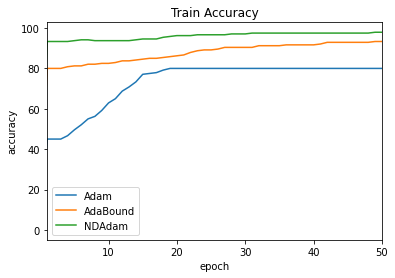

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accu_Adam)
plt.plot(train_accu_AdaBound)
plt.plot(train_accu_NDAdam)
plt.xlabel('epoch')
plt.xlim(1, epoch)
plt.ylabel('accuracy')
plt.legend(['Adam','AdaBound','NDAdam'])
plt.title('Train Accuracy')

plt.show()

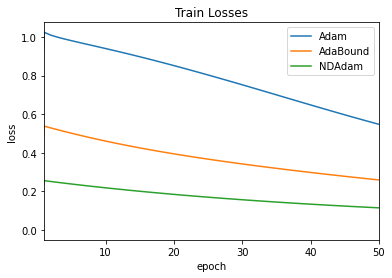

In [ ]:
plt.plot(train_losses_Adam)
plt.plot(train_losses_AdaBound)
plt.plot(train_losses_NDAdam)
plt.xlabel('epoch')
plt.xlim(1, epoch)
plt.ylabel('loss')
plt.legend(['Adam','AdaBound','NDAdam'])
plt.title('Train Losses')

plt.show()

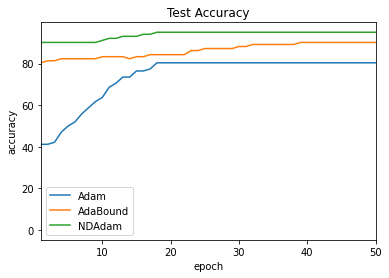

In [ ]:
plt.plot(eval_accu_Adam)
plt.plot(eval_accu_AdaBound)
plt.plot(eval_accu_NDAdam)
plt.xlabel('epoch')
plt.xlim(1, epoch)
plt.ylabel('accuracy')
plt.legend(['Adam','AdaBound','NDAdam'])
plt.title('Test Accuracy')

plt.show()

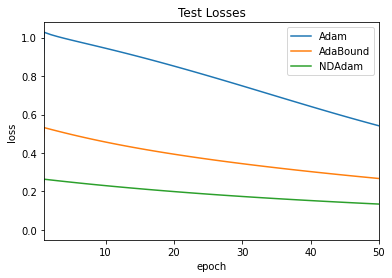

In [ ]:
plt.plot(eval_losses_Adam)
plt.plot(eval_losses_AdaBound)
plt.plot(eval_losses_NDAdam)
plt.xlabel('epoch')
plt.xlim(1, epoch)
plt.ylabel('loss')
plt.legend(['Adam','AdaBound','NDAdam'])
plt.title('Test Losses')

plt.show()